In [1]:
import Revise
import PyCall
using Printf
import Serialization
import GLRenderer as GL
import PoseComposition: Pose
import PyCall
import LinearAlgebra
import ThreeDP3 as T
import Images as I
import GLRenderer as GL
import MiniGSG as S
import NearestNeighbors as NN
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
using Gen
import Rotations as R
import DataStructures as DS
import MeshCatViz


┌ Info: Precompiling ThreeDP3 [d150788f-97db-4fd8-87b1-f1290d607c8d]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **



LoadError: InitError: could not load library "/home/nishadg/.julia/artifacts/b069ad81d556658ea64a543367e128e535fab269/lib/libgio-2.0.so"
/home/nishadg/.julia/artifacts/b069ad81d556658ea64a543367e128e535fab269/lib/libgobject-2.0.so.0: undefined symbol: g_uri_ref
during initialization of module Glib_jll

In [2]:
import MeshCatViz
MeshCatViz.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/nishadg/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

Opening in existing browser session.


In [3]:
rosbag = PyCall.pyimport("rosbag")
cv2 = PyCall.pyimport("cv2")
bridge = PyCall.pyimport("cv_bridge")
rospy = PyCall.pyimport("rospy")
pyrsc = PyCall.pyimport("pyransac3d")

ROOT_DIR = "/home/nishadg/Downloads/image_data"
rgb_topic = "/camera_A/color/image_raw_throttled"
depth_topic = "/camera_A/depth/image_rect_raw_throttled"

cv_bridge = bridge.CvBridge()

PyObject <cv_bridge.core.CvBridge object at 0x7fd84c0fc490>

In [4]:
bag = rosbag.Bag("/home/nishadg/Downloads/camera_A.orig.bag")

for (topic, msg, t) in bag.read_messages(topics=[rgb_topic, depth_topic])
    fn = @sprintf("%.6f", (rospy.rostime.Time.to_nsec(t)/1e9) - 1580300000) 
    if topic==rgb_topic
        cvimg = cv_bridge.imgmsg_to_cv2(msg, desired_encoding="bgr8")
        out_fn = joinpath(ROOT_DIR, "color", fn * ".png")
        #print "RGB: ", fn, cvimg.max(), type(cvimg), cvimg.dtype
    elseif topic==depth_topic
        cvimg = cv_bridge.imgmsg_to_cv2(msg, desired_encoding="16UC1")
        out_fn = joinpath(ROOT_DIR, "depth",fn * ".png")
    end
    cv2.imwrite(out_fn, cvimg)
end


┌ Error: Error watching manifest
│   exception = (InterruptException(), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fd93a978874, Ptr{Nothing} @0x00007fd80ae184fa])
└ @ Revise /home/nishadg/.julia/packages/Revise/3RMhb/src/pkgs.jl:563


LoadError: InterruptException:

In [13]:
bag.get_type_and_topic_info()

(Dict{Any, Any}("sensor_msgs/Image" => "060021388200f6f0f447d0fcd9c64743", "sensor_msgs/CameraInfo" => "c9a58c1b0b154e0e6da7578cb991d214"), Dict{Any, Any}("/camera_A/color/camera_info" => ("sensor_msgs/CameraInfo", 31162, 1, 44.79514701013532), "/camera_A/color/custom_cal" => ("sensor_msgs/CameraInfo", 31161, 1, 44.73804965200928), "/camera_A/depth/camera_info" => ("sensor_msgs/CameraInfo", 31161, 1, 40.919440203314096), "/camera_A/color/image_raw_throttled" => ("sensor_msgs/Image", 1010, 1, 0.9742440980510026), "/camera_A/depth/image_rect_raw_throttled" => ("sensor_msgs/Image", 1016, 1, 0.9825498764873928)))

In [14]:
for (topic, msg, t) in bag.read_messages(topics=["/camera_A/color/custom_cal"])
    print("color camera info\n", msg)
    intrinsics = GL.CameraIntrinsics(msg.width,msg.height, msg.K[1],msg.K[5],msg.K[3],msg.K[6], 0.01, 5000.0)
    Serialization.serialize(joinpath(ROOT_DIR, "color.intrinsics"), intrinsics)
    break
end
println("\n\n\n")
for (topic, msg, t) in bag.read_messages(topics=["/camera_A/depth/camera_info"])
    print("depth camera info\n", msg)
    intrinsics = GL.CameraIntrinsics(msg.width,msg.height, msg.K[1],msg.K[5],msg.K[3],msg.K[6], 0.01, 5000.0)
    Serialization.serialize(joinpath(ROOT_DIR, "depth.intrinsics"), intrinsics)
    break
end



color camera info
PyObject header: 
  seq: 1
  stamp: 
    secs: 1616788269
    nsecs:  84788561
  frame_id: "camera_A_color_optical_frame"
height: 1080
width: 1920
distortion_model: "plumb_bob"
D: [0.069644, -0.154332, -0.004702, 0.004893, 0.0]
K: [1342.451693, 0.0, 1005.799801, 0.0, 1339.678018, 545.304949, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [1331.703369, 0.0, 1022.047547, 0.0, 0.0, 1354.164185, 541.6677, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False



depth camera info
PyObject header: 
  seq: 2671
  stamp: 
    secs: 1616788269
    nsecs: 151479006
  frame_id: "camera_A_depth_optical_frame"
height: 720
width: 1280
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [629.90380859375, 0.0, 640.0660400390625, 0.0, 629.90380859375, 357.8631286621094, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [629.90380859375, 0.0, 640.0660400390625, 0.0, 

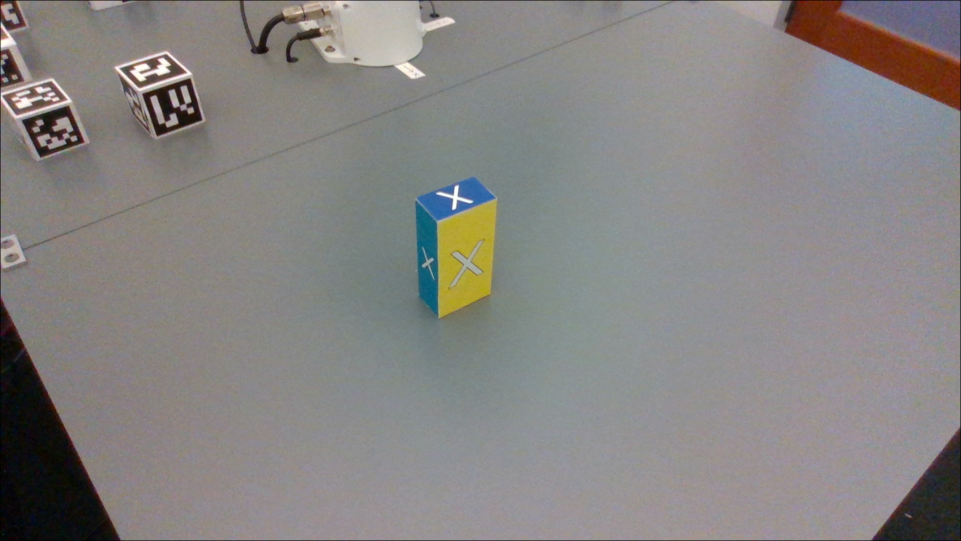

In [243]:
gt_rgb_image = T.load_rgb("/home/nishadg/Downloads/image_data/color/36488292.720789.png");
rgb_img = I.colorview(I.RGB, permutedims(Float64.(gt_rgb_image)./255.0, (3,1,2)))

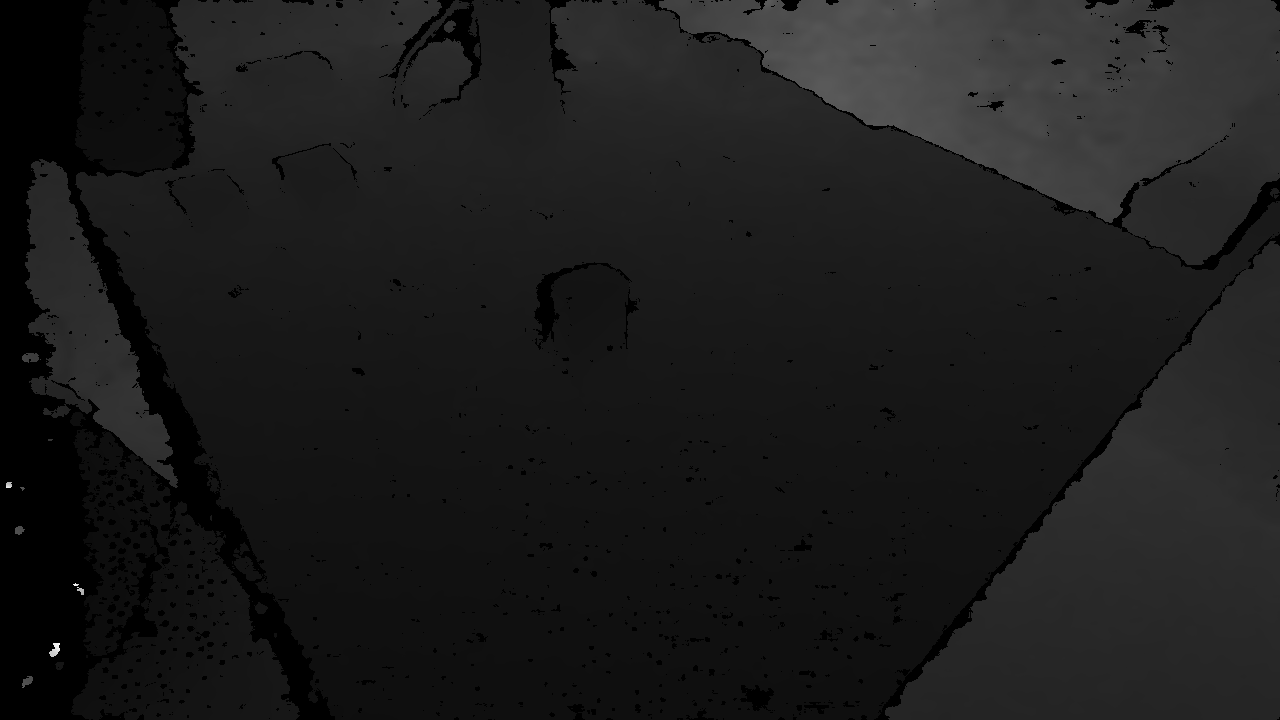

In [244]:
# gt_depth_image = T.load_depth("/home/nishadg/Downloads/image_data/depth/36488272.991643.png")
gt_depth_image = T.load_depth("/home/nishadg/Downloads/image_data/depth/36488292.383230.png")
gt_depth_image_viz = I.colorview(I.Gray, gt_depth_image ./ maximum(gt_depth_image))

In [245]:
original_camera = Serialization.deserialize(joinpath(ROOT_DIR, "depth.intrinsics"))
camera = T.scale_down_camera(original_camera, 2.0)
scale_up_factor = 1.0
cloud = GL.flatten_point_cloud(GL.depth_image_to_point_cloud(gt_depth_image ./ 10.0 * scale_up_factor, original_camera))
cloud = cloud[:, cloud[3,:] .> 0.1]
cloud = cloud[:, cloud[3,:] .< 90.0]
MeshCatViz.viz(cloud ./100.0)

MeshCat Visualizer with path /meshcat/cloud1 at http://127.0.0.1:8700

In [246]:
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(transpose(cloud), 0.01)
best_inliers = best_inliers .+ 1
# sub_cloud = cloud[:, best_inliers]
# MeshCatViz.viz(sub_cloud )
MeshCatViz.reset_visualizer()
sub_cloud = cloud[:, best_inliers]
MeshCatViz.viz(sub_cloud ./ 100.0)

MeshCat Visualizer with path /meshcat/cloud1 at http://127.0.0.1:8700

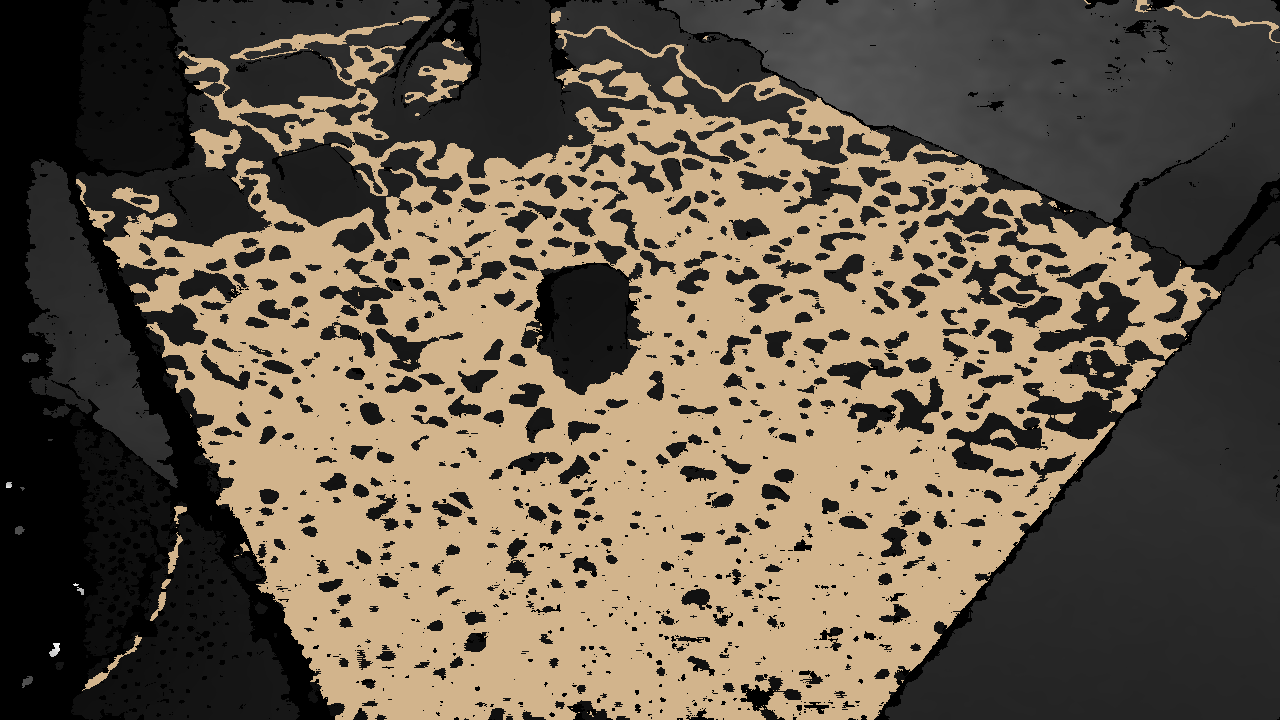

In [247]:
using Einsum
unflattened_cloud = GL.depth_image_to_point_cloud(gt_depth_image ./ 10.0 * scale_up_factor, original_camera)
x = best_eq[1:3]
Q = zeros(size(unflattened_cloud)[1:2]...)
@einsum Q[i,j] = unflattened_cloud[i,j,k] * x[k]
Q = abs.(Q .+ best_eq[4]) .< 0.5
overlay_surface_detection_img = convert.(I.RGBA, gt_depth_image_viz)
overlay_surface_detection_img[Q] .= I.colorant"tan"
overlay_surface_detection_img

In [248]:
a,b,c,d = best_eq
if c > 0.0
    println("flip")
    a,b,c,d = -1.0 .* [a,b,c,d]
end
@show a,b,c,d
shift = -d/c
q = T.rotation_between_two_vectors([a,b,c], [0.0, 0.0, 1.0])
camera_pose = inv(Pose([0.0, 0.0, shift], inv(q)))

transformed_cloud = T.move_points_to_frame_b(cloud, camera_pose)
MeshCatViz.viz(transformed_cloud ./ 50.0)


flip
(a, b, c, d) = (0.028171320657577503, -0.7050655531243701, -0.708582347006919, 53.57774804747882)


MeshCat Visualizer with path /meshcat/cloud1 at http://127.0.0.1:8700

In [281]:
object_bboxs = [
    S.Box([6.5, 6.5, 7.5] .* scale_up_factor ...),
    S.Box([6.5, 4.0, 14.0] .* scale_up_factor ...),    
]

all_ids = collect(1:length(object_bboxs))

renderer = GL.setup_renderer(camera, GL.DepthMode())
for bbox in object_bboxs
    v,n,f = GL.box_mesh_from_dims([bbox.sizeX, bbox.sizeY, bbox.sizeZ])
    GL.load_object!(renderer, v, f)
end

function get_cloud_from_ids_and_poses(ids, poses, camera_pose)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.flatten_point_cloud(GL.depth_image_to_point_cloud(depth_image, camera))
    cloud = cloud[:,cloud[3,:] .< (camera.far - 1.0)]
    if size(cloud)[2] == 0
        cloud = zeros(3,1)
    end
    cloud
end

get_cloud_func(id,p) = T.move_points_to_frame_b(T.voxelize(get_cloud_from_ids_and_poses(
                                [id], [p], camera_pose),resolution), camera_pose)

number of devices found 4
Loaded EGL 1.5 after reload.


libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


get_cloud_func (generic function with 1 method)

In [282]:
valid = fill(true, size(transformed_cloud)[2])
valid[best_inliers] .= false
cut_cloud = transformed_cloud[:, valid]
cut_cloud = cut_cloud[:, cut_cloud[3,:] .> 0.8]
MeshCatViz.viz(cut_cloud)

resolution =0.5
obs_cloud = T.voxelize(cut_cloud, resolution)
MeshCatViz.viz(obs_cloud ./50.0)

assign = T.dbscan_cluster(obs_cloud; radius= 0.5,min_cluster_size=200);
entities = T.get_entities_from_assignment(obs_cloud, assign);
@show size(entities)

sort!(entities,by=x->size(x)[2],rev=true);

size(entities) = (7,)


In [283]:
obs_blob = entities[1]
MeshCatViz.reset_visualizer()
MeshCatViz.viz(obs_blob ./ 50.0)

MeshCat Visualizer with path /meshcat/cloud1 at http://127.0.0.1:8700

In [252]:
parent_box = S.Box(200.0,200.0,0.25)
parent_pose = Pose(0.0, 0.0, 0.0)
parent_face = :top

:top

In [253]:
function object_recognition(obs_blob)


    c1_tree = NN.KDTree(obs_blob)
    id_to_face_cloud_and_score =  DS.DefaultDict{Any,Vector{Any}}(()->[])

    for id in all_ids
        for child_face in S.BOX_SURFACE_IDS
            child_box = object_bboxs[id]
            (x,y,ang) = T.icp_project_to_planar_contact(
                obs_blob, p -> get_cloud_func(id,p),
                parent_pose, parent_box, parent_face,
                child_box, child_face,
                0.0, 0.0, Gen.uniform(0.0, 2*pi);
                c1_tree= c1_tree, outer_iterations=10
            )

            contact = S.ShapeContact(parent_face, Real[], child_face, Real[], S.PlanarContact(x,y,ang))
            p = parent_pose * S.getRelativePoseFromContact(parent_box, child_box, contact)
            c = get_cloud_func(id,p)
            score = Gen.logpdf(
                T.uniform_mixture_from_template,
                obs_blob, c, 0.001, 0.5*2,(-1000.0, 1000.0, -1000.0,1000.0,-1000.0,1000.0)
            )

            push!(id_to_face_cloud_and_score[id], (face=child_face, cloud=c, score=score, pose=p, contact_params=(x,y,ang)))
        end
    #     println(size(id_to_face_cloud_and_score[id]))
        sort!(id_to_face_cloud_and_score[id],by=x->x.score,rev=true)
    end

    scores = [id_to_face_cloud_and_score[id][1].score for id in all_ids]
    perm = sortperm(-scores)
    best_score_id = perm[1]
    c = id_to_face_cloud_and_score[best_score_id][1].cloud
    best_pose = id_to_face_cloud_and_score[best_score_id][1].pose
    (id=best_score_id, pose=best_pose, c=c)
end

object_recognition (generic function with 1 method)

In [223]:
function stack_classification(obs_blob)
    c1_tree = NN.KDTree(obs_blob)
    id_to_face_cloud_and_score =  DS.DefaultDict{Any,Vector{Any}}(()->[])

    for id in all_ids
        for child_face in S.BOX_SURFACE_IDS
            child_box = object_bboxs[id]
            (x,y,ang) = T.icp_project_to_planar_contact(
                obs_blob, p -> get_cloud_func(id,p),
                parent_pose, parent_box, parent_face,
                child_box, child_face,
                0.0, 0.0, Gen.uniform(0.0, 2*pi);
                c1_tree= c1_tree, outer_iterations=10
            )

            contact = S.ShapeContact(parent_face, Real[], child_face, Real[], S.PlanarContact(x,y,ang))
            p = parent_pose * S.getRelativePoseFromContact(parent_box, child_box, contact)
            c = get_cloud_func(id,p)
            score = Gen.logpdf(
                T.uniform_mixture_from_template,
                obs_blob, c, 0.001, 0.5*2,(-1000.0, 1000.0, -1000.0,1000.0,-1000.0,1000.0)
            )

            push!(id_to_face_cloud_and_score[id], (face=child_face, cloud=c, score=score, pose=p, contact_params=(x,y,ang)))
        end
    #     println(size(id_to_face_cloud_and_score[id]))
        sort!(id_to_face_cloud_and_score[id],by=x->x.score,rev=true)
    end

    id_and_id_to_face_cloud_and_score =  DS.DefaultDict{Any,Vector{Any}}(()->[])

    for id_1 in all_ids

        data = id_to_face_cloud_and_score[id_1][1]

        unexplained_idxs = T.get_unexplained_points(obs_blob, data.cloud)
        unexplained_points = obs_blob[:, unexplained_idxs]

        c1_tree = NN.KDTree(unexplained_points)

        parent_pose = data.pose
        parent_face = T.opposite_face(data.face)
        parent_box = object_bboxs[id_1]

        for id in all_ids
            for child_face in S.BOX_SURFACE_IDS
                child_box = object_bboxs[id]

                (x,y,ang) = T.icp_project_to_planar_contact(
                    unexplained_points, p -> get_cloud_func(id,p), parent_pose, parent_box, parent_face,
                    child_box, child_face,
                    0.0,0.0,0.0;
                    c1_tree= c1_tree
                )

                contact = S.ShapeContact(parent_face, Real[], child_face, Real[], S.PlanarContact(x,y,ang))
                p = parent_pose * S.getRelativePoseFromContact(parent_box, child_box, contact)
                c = get_cloud_func(id,p)
                score = Gen.logpdf(
                    T.uniform_mixture_from_template,
                    unexplained_points, c, 0.01, 0.5*2,(-1000.0, 1000.0, -1000.0,1000.0,-1000.0,1000.0)
                )

                push!(id_and_id_to_face_cloud_and_score[(id_1,id)], 
                    (face=child_face, cloud=c, score=score, pose=p, contact_params=(x,y,ang)))
            end
            sort!(id_and_id_to_face_cloud_and_score[(id_1,id)],by=x->x.score,rev=true)
        end
    end
    id_and_id_to_score = Dict()
    for id_1 in all_ids
        for id in all_ids
            pose_1 = id_to_face_cloud_and_score[id_1][1].pose
            pose_2 = id_and_id_to_face_cloud_and_score[(id_1,id)][1].pose


            c = T.move_points_to_frame_b(T.voxelize(get_cloud_from_ids_and_poses(
                                    [id_1,id], [pose_1, pose_2], camera_pose), 0.5), camera_pose)

            score = Gen.logpdf(
                T.uniform_mixture_from_template,
                obs_blob, c, 0.01, 0.5*2,(-1000.0, 1000.0, -1000.0,1000.0,-1000.0,1000.0)
            )
            id_and_id_to_score[(id_1,id)] = score
        end
    end
    id_and_id_to_score, id_to_face_cloud_and_score, id_and_id_to_face_cloud_and_score
end

# c = id_to_face_cloud_and_score[2][1].cloud
# MeshCatViz.reset_visualizer()
# MeshCatViz.viz(obs_blob ./100.0; color=I.colorant"black", channel_name=:obs_cloud)
# MeshCatViz.viz(c ./100.0; color=I.colorant"red", channel_name=:gen_cloud)


@time id_and_id_to_score, id_to_face_cloud_and_score, id_and_id_to_face_cloud_and_score = stack_classification(obs_blob);
(id_1,id) = argmax(id_and_id_to_score)
@show (id_1,id)
pose_1 = id_to_face_cloud_and_score[id_1][1].pose
pose_2 = id_and_id_to_face_cloud_and_score[(id_1,id)][1].pose


c = T.move_points_to_frame_b(T.voxelize(get_cloud_from_ids_and_poses(
                        [id_1,id], [pose_1, pose_2], camera_pose),0.5), camera_pose)
MeshCatViz.viz(obs_blob ./100.0; color=I.colorant"black", channel_name=:obs_cloud)
MeshCatViz.viz(c ./100.0; color=I.colorant"red", channel_name=:gen_cloud)

  4.048196 seconds (8.81 M allocations: 8.346 GiB, 2.67% gc time, 42.89% compilation time)
(id_1, id) = (1, 1)


MeshCat Visualizer with path /meshcat/gen_cloud at http://127.0.0.1:8700

In [168]:
id_pose = [
    (id=id_1,pose=pose_1),
    (id=id,pose=pose_2),   
];

In [285]:
@time id_pose = object_recognition.(entities);
[x.id for x in id_pose]

  7.541297 seconds (17.26 M allocations: 25.950 GiB, 3.23% gc time)


7-element Vector{Int64}:
 2
 1
 1
 2
 1
 2
 1

In [255]:
# sub_indices = [1,3]
sub_indices = [1]

1-element Vector{Int64}:
 1

In [256]:
MeshCatViz.reset_visualizer()
MeshCatViz.viz(obs_cloud ./100.0; color=I.colorant"black", channel_name=:obs_cloud)
c = get_cloud_from_ids_and_poses(
    [x.id for x in id_pose][sub_indices],
    [x.pose for x in id_pose][sub_indices],
    camera_pose
)
c = T.move_points_to_frame_b(c, camera_pose)
MeshCatViz.viz(c ./100.0; color=I.colorant"red", channel_name=:gen_cloud)

MeshCat Visualizer with path /meshcat/gen_cloud at http://127.0.0.1:8700

In [257]:
renderer_original = GL.setup_renderer(original_camera, GL.RGBBasicMode())
for bbox in object_bboxs
    v,n,f = GL.box_mesh_from_dims([bbox.sizeX, bbox.sizeY, bbox.sizeZ])
    GL.load_object!(renderer_original, v, n,f)
end
v,n,f = GL.box_mesh_from_dims([parent_box.sizeX, parent_box.sizeY, parent_box.sizeZ])
GL.load_object!(renderer_original, v, n,f)

number of devices found 4
Loaded EGL 1.5 after reload.


libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


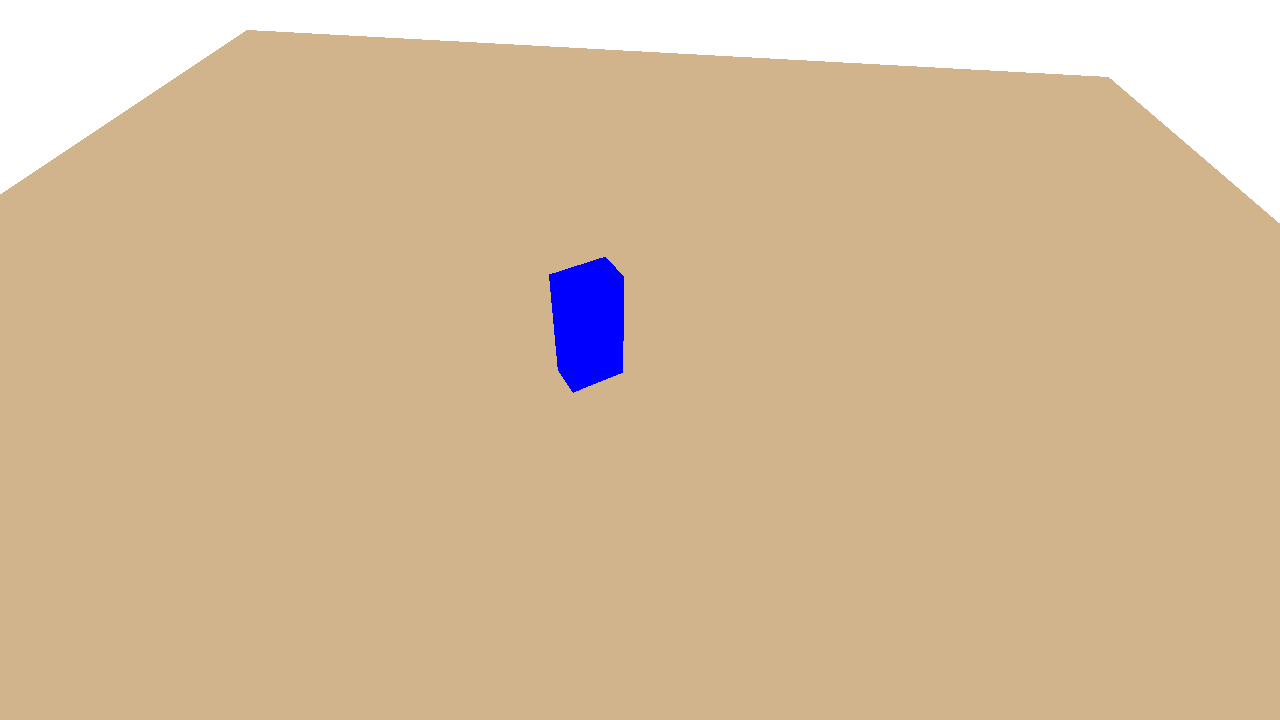

In [258]:
table_color = I.colorant"tan"
colors = [I.colorant"chocolate3", I.colorant"blue"]
rgb_img, _ = GL.gl_render(
    renderer_original,
    vcat([x.id for x in id_pose][sub_indices],[3]),
    vcat([x.pose for x in id_pose][sub_indices], [parent_pose]),
    vcat([colors[x.id] for x in id_pose][sub_indices], [table_color]),
    camera_pose)
img = I.colorview(I.RGBA, permutedims(Float64.(rgb_img), (3,1,2)))

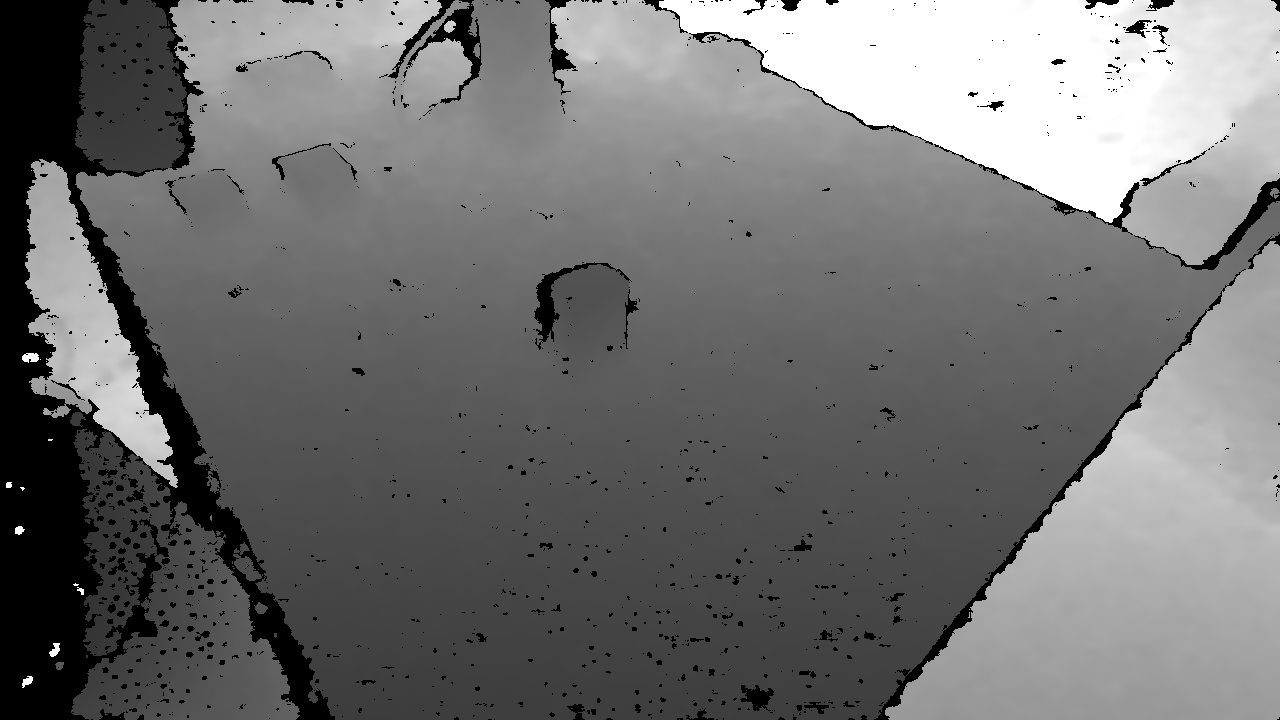

In [259]:
m = 2000.0
gt_img = I.colorview(I.Gray, clamp.(gt_depth_image,0.0,m) ./ m)

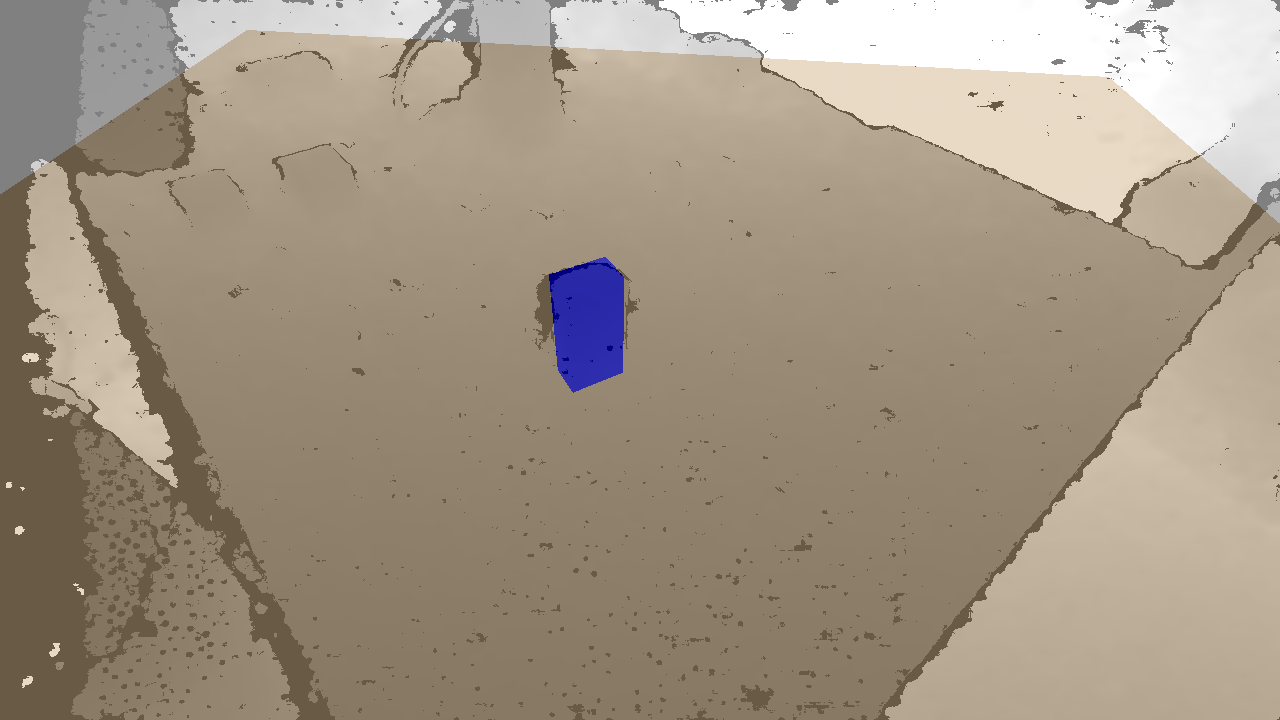

In [260]:
alpha = 0.5
alpha .* gt_img .+ (1.0 - alpha) .* img

In [278]:
MeshCatViz.reset_visualizer()
MeshCatViz.viz(obs_blob)

MeshCat Visualizer with path /meshcat/cloud1 at http://127.0.0.1:8700

In [279]:
MeshCatViz.viz_box(T.get_bbox_segments_point_list(object_bboxs[2], id_pose[1].pose) , :box;
color=colors[2])

MeshCat Visualizer with path /meshcat/box at http://127.0.0.1:8700

In [56]:
renderer_original = GL.setup_renderer(original_camera, GL.RGBMode())
for bbox in object_bboxs
    v,n,f = GL.box_mesh_from_dims([bbox.sizeX, bbox.sizeY, bbox.sizeZ])
    GL.load_object!(renderer_original, v, n,f)
end
v,n,f = GL.box_mesh_from_dims([parent_box.sizeX, parent_box.sizeY, parent_box.sizeZ])
GL.load_object!(renderer_original, v, n,f)

number of devices found 4
Loaded EGL 1.5 after reload.


libEGL warning: DRI2: failed to create dri screen
libEGL warning: DRI2: failed to create dri screen
Unable to initialize EGL


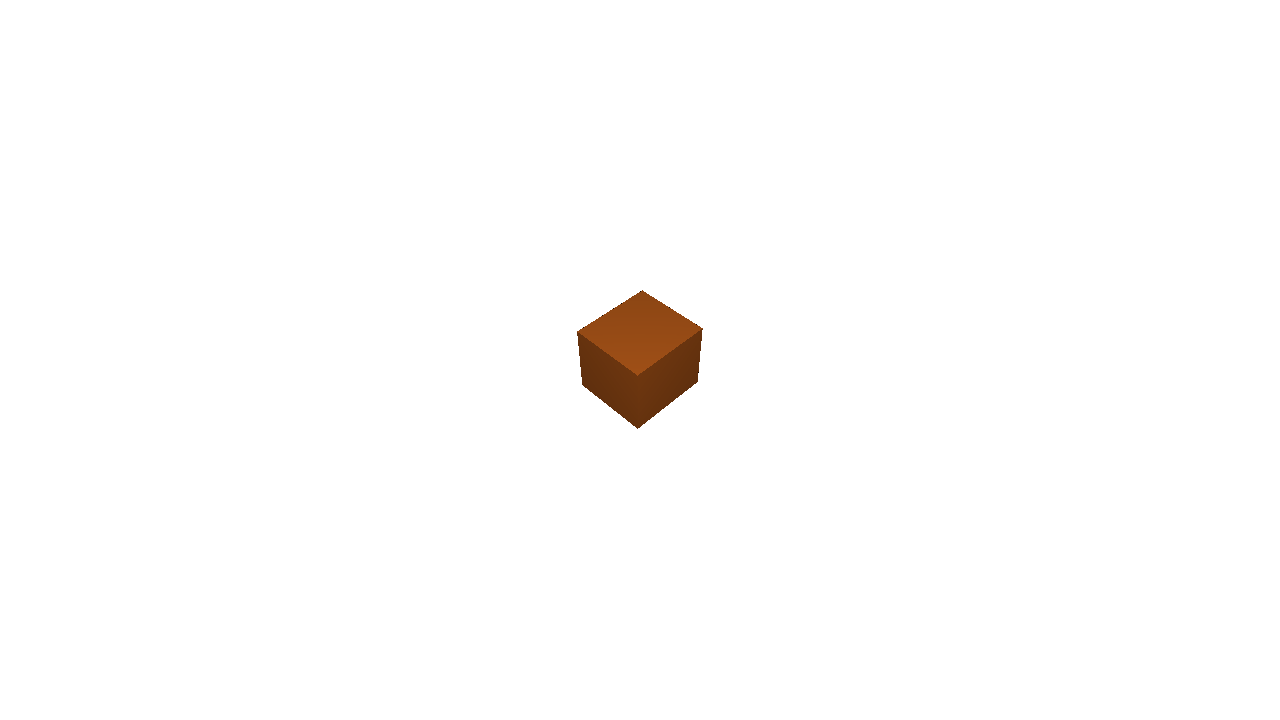

In [73]:
id = 1
rgb_img, _ = GL.gl_render(
    renderer_original,
    [id],
    [Pose([0.0, 0.0, 50.0], R.RotXYZ(pi/4, pi/4, 0.0))],
    [colors[id]],
    IDENTITY_POSE
)
img = I.colorview(I.RGBA, permutedims(Float64.(rgb_img), (3,1,2)))

In [62]:
renderer_original.gl_instance.lightpos

3-element Vector{Int64}:
 0
 0
 0